In [23]:
import pandas as pd, torch, numpy as np, matplotlib.pyplot as plt, time

# PART 1

In [24]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [25]:
trainX = torch.from_numpy(train.drop("DTH_CUM_CP", axis = 1).values).type(torch.float64)
trainY = torch.from_numpy(train["DTH_CUM_CP"].values.reshape(-1, 1)).type(torch.float64)

testX = torch.from_numpy(test.drop("DTH_CUM_CP", axis = 1).values).type(torch.float64)
testY = torch.from_numpy(test["DTH_CUM_CP"].values.reshape(-1, 1)).type(torch.float64)

coef = torch.tensor([
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040], # POS_50_59_CP
        [0.0300], # POS_60_69_CP
        [0.0300],
        [0.0300],
        [0.0300]
], dtype=testX.dtype)

if torch.cuda.is_available():
    testX = testX.to("cuda")
    testY = testY.to("cuda")
    trainX = trainX.to("cuda")
    trainY = trainY.to("cuda")
    coef = coef.to("cuda")

In [26]:
(testX[0] @ coef).item()

9.844

# PART 2

In [27]:
predictedY = torch.mm(testX, coef) # matrix multiplication

def r2_score(trueY, predictedY):
    trueY_mean = torch.mean(trueY, dtype=torch.float64).item()
    SStot = torch.square(trueY - trueY_mean).sum().item()
    SSreg = torch.square(trueY - predictedY).sum().item()
    improvement = SStot - SSreg
    r2 = improvement/SStot
    return r2

r2_score(testY, predictedY)

0.41103503288417204

# PART 3

In [28]:
x = torch.tensor(0.0, requires_grad=True)

optimizer = torch.optim.SGD([x], lr=0.1)

x_values = []
y_values = []

for i in range(30):
    optimizer.zero_grad()
    y = x**2 - 8*x + 19
    y.backward()
    optimizer.step()
    x_values.append(x.item())
    y_values.append(y.item())
    # print(x, y)

x.item()

3.9950480461120605

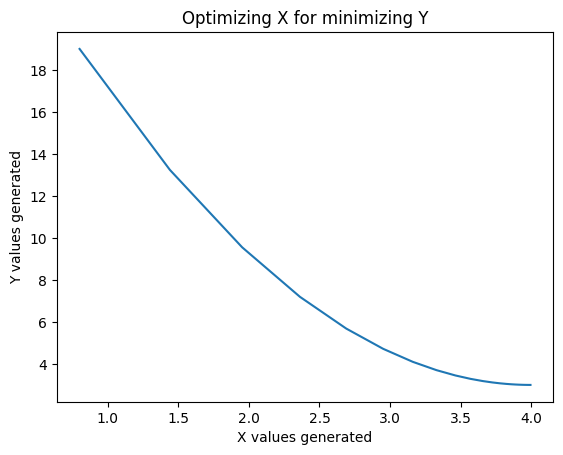

In [29]:
plt.plot(x_values, y_values)
plt.xlabel("X values generated")
plt.ylabel("Y values generated")
plt.title("Optimizing X for minimizing Y")
plt.show()

# PART 4

In [30]:
ds = torch.utils.data.TensorDataset(trainX.type(torch.float32), trainY.type(torch.float32))
dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=25)

model = torch.nn.Linear(trainX.shape[1], trainY.shape[1], dtype=torch.float32)
optimizer = torch.optim.SGD([model.weight, model.bias], lr = 0.000001)
loss_fn = torch.nn.MSELoss()

start = time.time()
for epoch in range(100):
    for batchX, batchY in dl:
        predictedY = model(batchX)
        loss = loss_fn(batchY, predictedY)
        loss.backward()       # update weight.grad and bias.grad
        optimizer.step()      # update weight and bias based on the gradients
        optimizer.zero_grad()    
end = time.time()
print("Execution time:", (end - start) * 1000, "milliseconds") # TOTAL TIME

Execution time: 1911.9563102722168 milliseconds


In [31]:
r2_score(testY.type(torch.float32), model(testX.type(torch.float32)))

0.5834580237369462

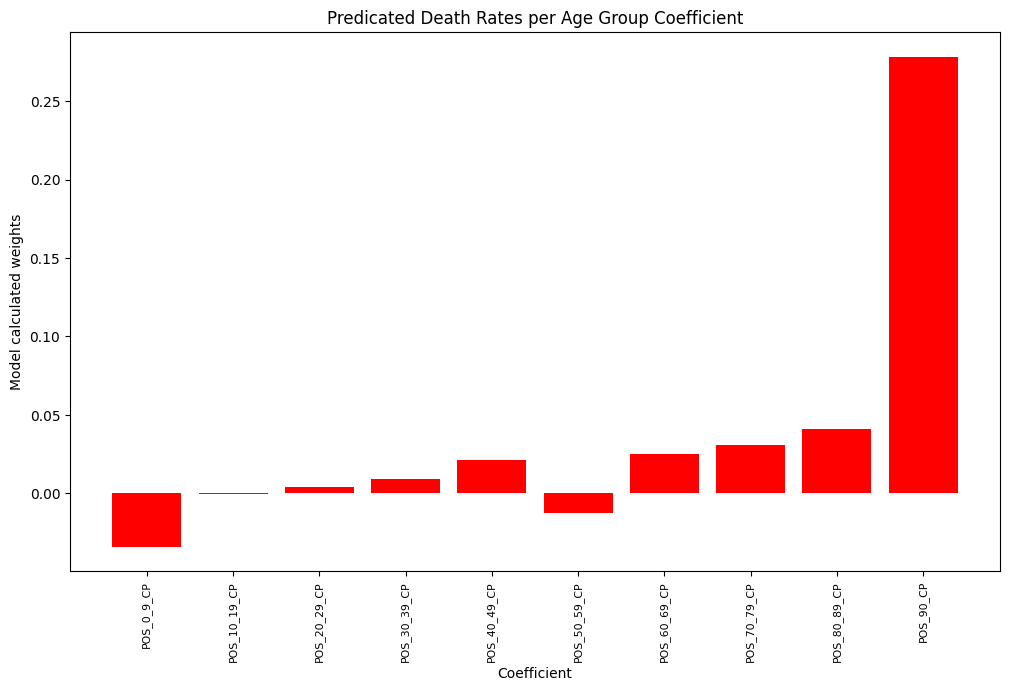

In [32]:
fig = plt.figure(figsize=(12, 7))
plt.bar(list(train.columns[:-1]), model.weight.tolist()[0], color = "red")
plt.xticks(rotation = 90, fontsize = 7.8)
plt.xlabel("Coefficient")
plt.ylabel("Model calculated weights")
plt.title("Predicated Death Rates per Age Group Coefficient")
plt.show()